In [2]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from dhi.dsmatch import local_bucket
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import warnings

Matplotlib is building the font cache; this may take a moment.


In [ ]:
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

## SME Instructions:

Below are the instructions given to the SME annotators with respect to experience. As you can see, there are several items that went into their decision when making a rating. The engineered feature from prior work on parsing out YoE from resumes & JD's only focuses on overall years of experience (which is also an imperfect measure based on an average from BG and internal tools, that sometimes includes education and sometimes not).

Experience (years of experience, job duties, seniority, etc.)

What to ignore:

- Formatting errors in either document
- Spoken language requirements
- Work authorization requirements
- Salary requirements
- Security clearance requirements
- Candidate's location relative to the job location

## Initial data load

Using a pre-processed dataset that Sfurti shared with me that includes the parsed out YoE from the labelled SME consensus dataset.

In [3]:
parsed_SME_df = read_csv((os.path.join(local_bucket,'data', 'dice', 'new-bg-parsing-2022','labeled_data_for_victor_EDA_analysis.csv')))

In [4]:
parsed_SME_df.head()

,Unnamed: 0,snapshot_id,year,month,day,worker_email,experience,titles,skills,overall,...,resume_bg_parse_sandbox,description_bg_parse_sandbox,description_bg_skills_sandbox,resume_bg_skills_sandbox,profile_skill_data_pond,profile_skills_exp,overall_exp_res_prof,overall_experience_job,overall_exp_res_bg,overall_experience_resume
0,0,f699d3fa-5fcd-553d-9326-8b6d9a7ab0b6,2021,2,5,thellmuth@iqclarity.com,5.0,4.0,4.0,4.0,...,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['Apigee', 'TIBCO']","['ANSI X12', 'Apache Subversion (SVN)', 'Apige...","['Integration', ' TIBCO', ' WTX', ' ASC X12', ...","['10', '10', '10', '10', '10', '10', '10', '10...",10,0.5,12.090411,11.045205
1,1,6781e17d-0d57-5339-91c7-b9ea89aa0f66,2021,2,5,thellmuth@iqclarity.com,3.0,2.0,2.0,2.0,...,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['AWS Elastic Compute Cloud (EC2)', 'Ansible',...","['AWS Lambda', 'Accounting Systems', 'Apache A...","['Architecture', ' VoIP', ' Ubuntu', ' Data ce...","['35', '29', '29', '27', '26', '25', '25', '25...",25,8.0,25.000000,25.000000
2,2,8f026a65-0404-5a03-b96f-32f13535347e,2021,2,3,thellmuth@iqclarity.com,3.0,3.0,3.0,3.0,...,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['Code Reviews', 'Communication Skills', 'Cont...","['Authentication', 'AutoCAD', 'Calculus', 'Cat...","['CSS', ' Express.js', ' GitHub', ' HTML', ' H...","['2', '2', '1', '2', '2', '2', '0', '2', '2', ...",2,7.0,2.000000,2.000000
3,3,9dc1f84a-dc8d-5e2b-bddd-a0d38a9b5248,2021,2,7,thellmuth@iqclarity.com,4.0,4.0,4.0,4.0,...,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['Agency Selection', 'Bash', 'Change Managemen...","['Anomaly Detection', 'Authentication', 'COBIT...","['DNS', ' Security operations', ' Authenticati...","['5', '4', '4', '4', '4', '4', '4', '4', '3', ...",5,NaN,11.175342,8.087671
4,4,010d401d-295d-56f6-883d-188b9d2e82fb,2021,2,5,thellmuth@iqclarity.com,4.0,4.0,4.0,4.0,...,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['C++', 'Data Science', 'Data Structures', 'De...","['API Management', 'AWS CodeBuild', 'AWS Elast...","['javascript / nodejs', ' DevOps Systems Autom...","['3', '7', '2', '3', '10', '7', '4', '2', '11'...",9,NaN,12.509589,10.754795


In [5]:
# eliminate HTML tags from JD's for ease of review
parsed_SME_df['job_description'] = parsed_SME_df.apply(lambda x: BeautifulSoup(x['job_description'], 'html.parser').text, axis=1)

In [6]:
cols = ['experience', 'titles', 'skills', 'overall', 'job_description', 'resume']

### Distribution of Experience vs. other ratings

It appears that SME's provided relatively higher scores to experience than the rest of the sub-ratings, and in relation to the overall score as well. The other two categories of titles and skills align more closely with the overall rating distribution, but experience tends to bias towards higher scores. This could be due to the fact that their instructions included additional factors beyond the more explicit & straightforward categories for job title & skills.

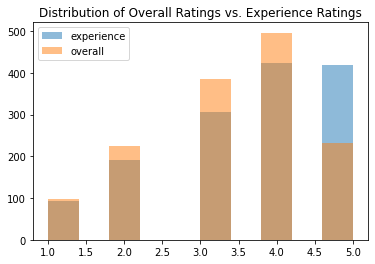

In [47]:
plt.hist(parsed_SME_df['experience'], alpha=.5)
plt.hist(parsed_SME_df['overall'], alpha=.5)
plt.legend(['experience', 'overall'])
plt.title('Distribution of Overall Ratings vs. Experience Ratings')
plt.show()

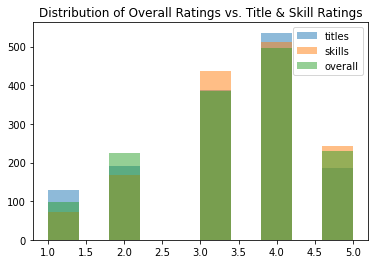

In [49]:
plt.hist(parsed_SME_df['titles'], alpha=.5)
plt.hist(parsed_SME_df['skills'], alpha=.5)
plt.hist(parsed_SME_df['overall'], alpha=.5)
plt.legend(['titles', 'skills', 'overall'])
plt.title('Distribution of Overall Ratings vs. Title & Skill Ratings')
plt.show()

In [9]:
cols = ['experience','job_description', 'resume', 'overall_exp_res_prof','overall_experience_job','overall_exp_res_bg','overall_experience_resume']
parsed_SME_df.head()[cols]

,experience,job_description,resume,overall_exp_res_prof,overall_experience_job,overall_exp_res_bg,overall_experience_resume
0,5.0,"Hi,Greeting from Conch Technologies IncPositio...",﻿ – IBM DataPower/API Consultant \r\nSUMMARY:\...,10,0.5,12.090411,11.045205
1,3.0,ZIO Technologies is an IT solutions company p...,﻿\r\n\r\nJEFFREY \r\n | | C2C only | Visa US...,25,8.0,25.000000,25.000000
2,3.0,Remote/Telecommuting position -- Candidates ...,\r\nI've been making fullstack web application...,2,7.0,2.000000,2.000000
3,4.0,Specifics Technical Qualifications:Practical k...,"- MS (InfoSec), M. Tech (CSE), B. Tech (CSE) ...",5,NaN,11.175342,8.087671
4,4.0,We are the software spinoff of a prestigious H...,B. ...,9,NaN,12.509589,10.754795


### Follow up from match 2707

It was determined that we would start iterating on the difference in total years of experience calculated from the JD minus the Resume to determine goodness of fit from an experience standpoint. I am making that column in `"years_diff"`, and for sake of visualizing general trends, I am also rounding the experience for overall experience and BG parsed experience

In [12]:
parsed_SME_df['years_diff'] = parsed_SME_df.apply(lambda x: x['overall_experience_job'] - x['overall_experience_resume'], axis=1)
parsed_SME_df['rounded_exp_res'] = round(parsed_SME_df['overall_experience_resume'])
parsed_SME_df['rounded_exp_res_bg'] = round(parsed_SME_df['overall_exp_res_bg'])

### Comments on below visualization

Similar to work done on match 2707 and initial EDA on YoE, this is an attempt to identify any patterns between the SME ratings and the difference in JD & resume years of experience. This graph is not super useful in identifying any trends, but was an initial foray

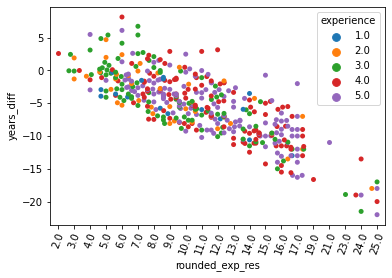

In [53]:
ax = sns.swarmplot(data=parsed_SME_df.dropna(), x="rounded_exp_res", y="years_diff", hue="experience")
ax.tick_params(axis='x', rotation=70)

### Comments:

This box & whisker plot shows the overall distribution of scores doesn't really differ with respect to `years_diff` (JD years - resume years). They all tend to center around the -4 year marker. Assuming that a better match from an experience standpoint is closer to 0 years of difference, one might expect to see a greater concentration of 1's towards the ends of the spectrum (i.e., greater distance of years away from what the JD is asking for). At least, one would expect to see the concentration of ones towards the positive end of the spectrum, i.e., JD's for which the resume is very poorly qualified.

Accordingly, one might expect to see the corresponding distributions for each rating to move in accordance with the # years of difference between JD & resume, but we see no such pattern.

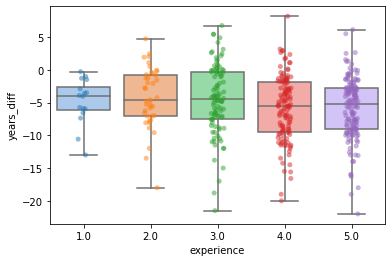

In [55]:
sns.boxplot(x="experience", y="years_diff", data=parsed_SME_df.dropna(0), whis=np.inf, palette='pastel')
sns.stripplot(x="experience", y="years_diff", data=parsed_SME_df.dropna(0), alpha=.5)
plt.show()

### Comments:

Below is another variation of the above, with a bit more detail on where the data are distributed. For example, it seems that 5's and 2's are somehat bi-modal, but not significantly enough to be useful

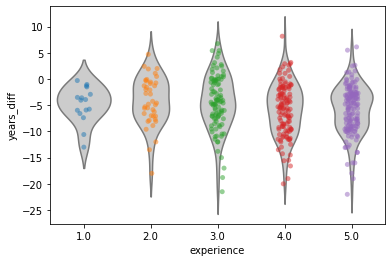

In [56]:
sns.violinplot(x="experience", y="years_diff", data=parsed_SME_df.dropna(0),
                    inner=None, color=".8")
sns.stripplot(x="experience", y="years_diff", data=parsed_SME_df.dropna(0), alpha=.5)
plt.show()

### Comments:

Another 2 attempts to find some useful patterns, but no such luck

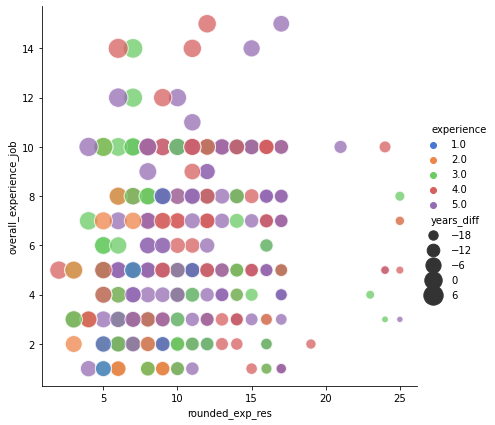

In [57]:
sns.relplot(x="rounded_exp_res", y="overall_experience_job", hue="experience", size="years_diff",
            sizes=(40, 400), alpha=.75, palette="muted",
            height=6, data=parsed_SME_df.dropna(0))

plt.show()

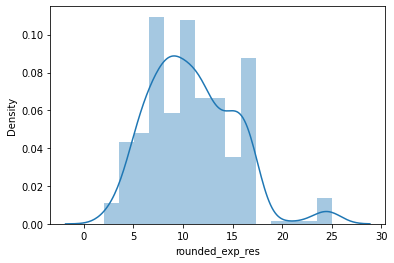

In [58]:
sns.distplot(parsed_SME_df.dropna(0)['rounded_exp_res'])
plt.show()

### Attempt to see how thresholds might align with the distribution of years_diff

below are some attempts to see how we might be able to use prior work on thresholds to potentially label each section accordingly. This could be a way we start to engineer our own score of YoE based on internal definitions of goodness of fit

In [18]:
def set_prediction_thresholds_from_labels(s: pd.Series):
    prediction_thresholds = s.value_counts(normalize=True).sort_index().cumsum().iloc[:-1].values
    return prediction_thresholds

In [22]:
set_prediction_thresholds_from_labels(parsed_SME_df.dropna(0)['experience'])

array([0.03782506, 0.13475177, 0.36643026, 0.65484634])

In [23]:
scaler = MinMaxScaler()

In [24]:
l = [np.percentile(parsed_SME_df.dropna(0)['years_diff'], i) for i in range(20, 120, 20)]
l

[-9.436986301369862,
 -6.3161643835616434,
 -3.7958904109589042,
 -1.2945205479452055,
 8.161643835616438]

/home/ec2-user/SageMaker/victor/.custom-miniconda/miniconda/envs/Python3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='years_diff', ylabel='Density'>

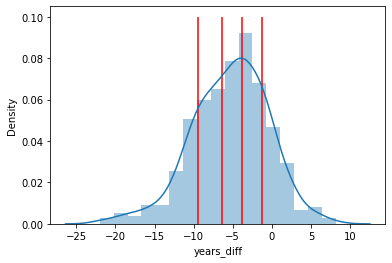

In [25]:
# job years - resume years
plt.vlines(l[:-1], 0, .1, color='red')
sns.distplot(parsed_SME_df.dropna(0)['years_diff'])

/home/ec2-user/SageMaker/victor/.custom-miniconda/miniconda/envs/Python3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


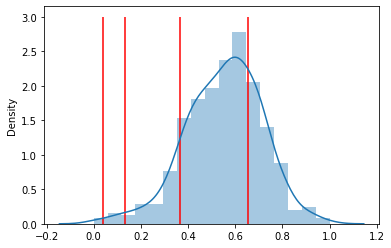

In [26]:
plt.vlines(set_prediction_thresholds_from_labels(parsed_SME_df.dropna(0)['experience']), 0, 3, color='red')
sns.distplot(scaler.fit_transform(np.array(parsed_SME_df.dropna(0)['years_diff']).reshape(-1, 1)))
plt.show()

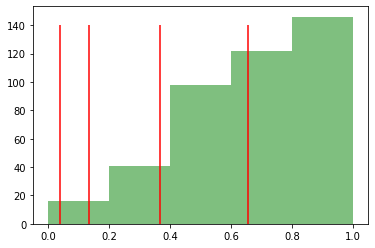

In [27]:
plt.vlines(set_prediction_thresholds_from_labels(parsed_SME_df.dropna(0)['experience']), 0, 140, color='red')
plt.hist(scaler.fit_transform(np.array(parsed_SME_df.dropna(0)['experience']).reshape(-1, 1)), color='green', alpha=.5, bins=5)
plt.show()

### Distribution of Scores over `years_diff`:

This is probably the most useful/telling graph in this EDA. It shows more clearly the aforementioned (box & whisker/violin plots above) analysis regarding `years_diff` utility in explaining the experience ratings. There don't seem to be any discernable patterns in how the experience ratings are showing up across our calculated years of experience. 

As previously mentioned, one might expect to find a tight distribution of 5's centered around the 0 on the graph, but we see almost identical distributions for all rating categories across all buckets for `years_diff`.

It is also concerning that there is such a strong concentration of 5's compared to other ratings. Is it really possible that all of these are definitely worthy of a 5? Possibly, there is quite a bit of variation in SME's ability to make consistent judgments across all domains, in addition to an imperfect feature engineered by calculating overall YoE.

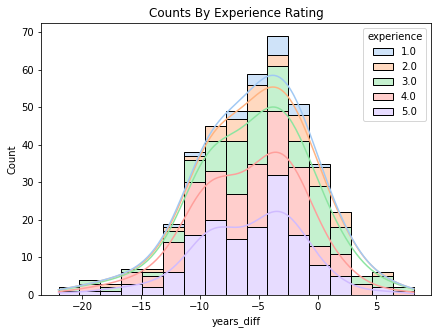

In [59]:
d = parsed_SME_df.dropna(0)
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=d, ax=ax, stat="count", multiple="stack",
             x="years_diff", kde=True,
             palette="pastel", hue="experience",
             element="bars", legend=True)
ax.set_title("Counts By Experience Rating")
ax.set_xlabel("years_diff")
ax.set_ylabel("Count")
plt.show()

### Comments:

below are similar attempts to suss out any discernable patterns by separating counts by experience rating. Again, it all just seems very noisy/not useful in building a YoE model

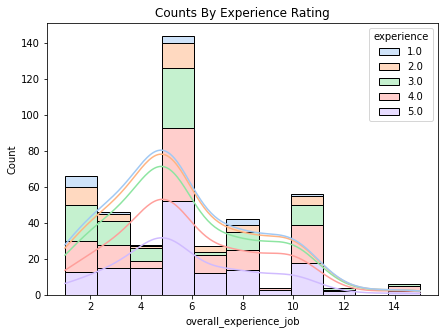

In [29]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=d, ax=ax, stat="count", multiple="stack",
             x="overall_experience_job", kde=True,
             palette="pastel", hue="experience",
             element="bars", legend=True)
ax.set_title("Counts By Experience Rating")
ax.set_xlabel("overall_experience_job")
ax.set_ylabel("Count")
plt.show()

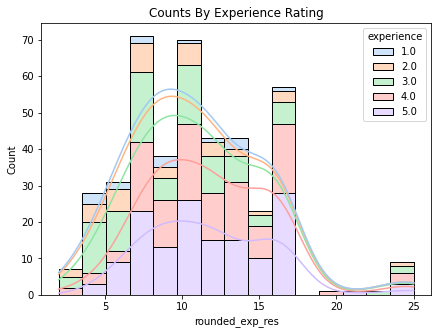

In [30]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=d, ax=ax, stat="count", multiple="stack",
             x="rounded_exp_res", kde=True,
             palette="pastel", hue="experience",
             element="bars", legend=True)
ax.set_title("Counts By Experience Rating")
ax.set_xlabel("rounded_exp_res")
ax.set_ylabel("Count")
plt.show()

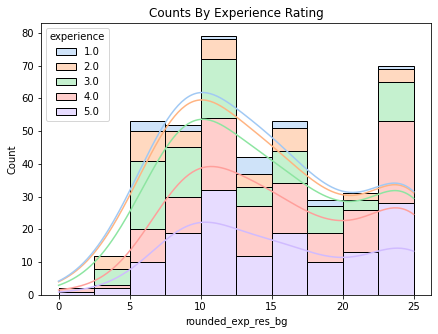

In [31]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=d, ax=ax, stat="count", multiple="stack",
             x="rounded_exp_res_bg", kde=True,
             palette="pastel", hue="experience",
             element="bars", legend=True)
ax.set_title("Counts By Experience Rating")
ax.set_xlabel("rounded_exp_res_bg")
ax.set_ylabel("Count")
plt.show()

### Comments:
Here is a pairplot (collection of scatter plots) to see if there are any correlations/interesting trends between some of the variables in an attempt to explain experience rating. No real helpful patterns here either.

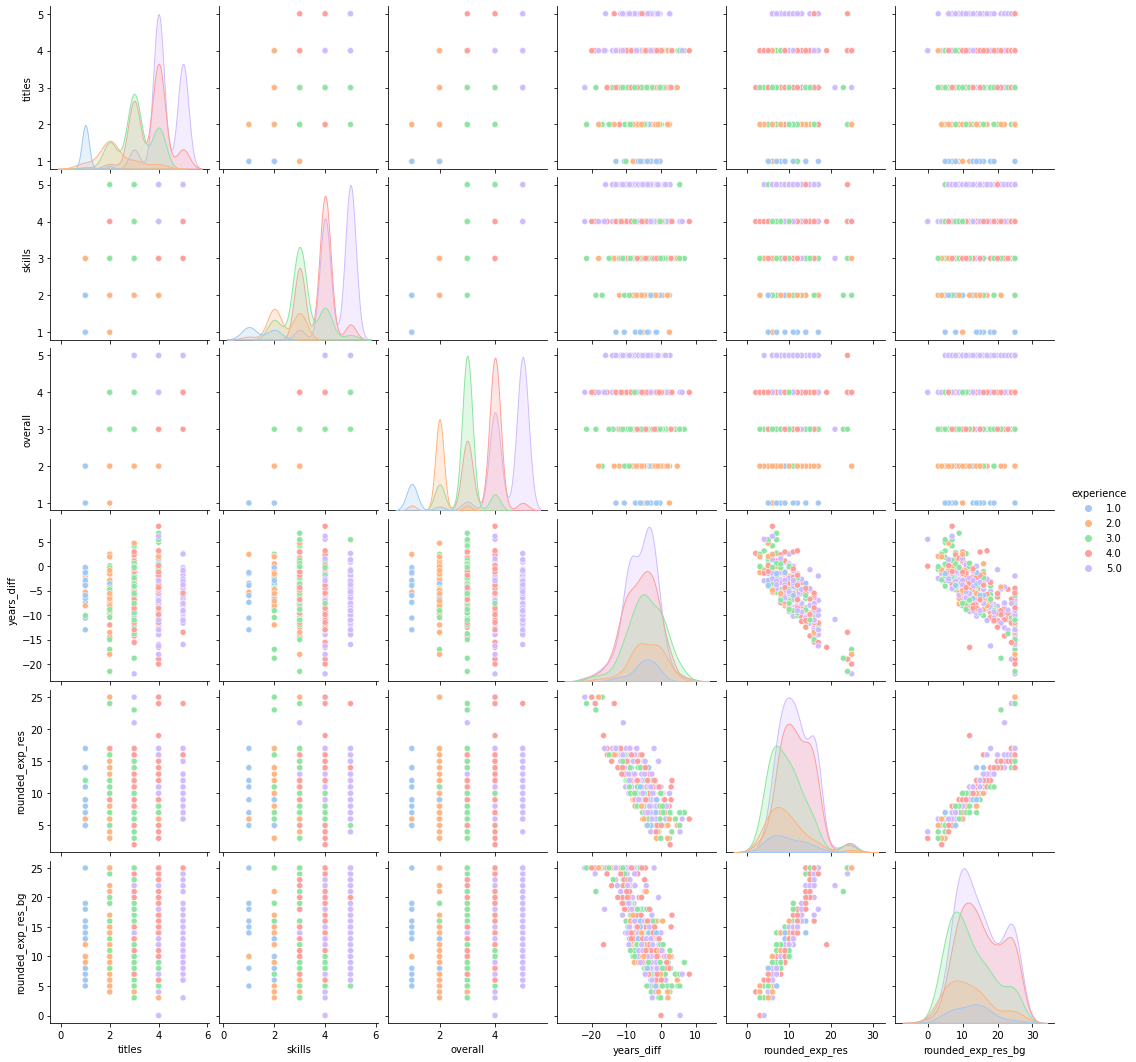

In [32]:
cols = ['experience', 'titles', 'skills', 'overall','years_diff', 'rounded_exp_res', 'rounded_exp_res_bg']
sns.pairplot(data=parsed_SME_df.dropna(0)[cols], hue='experience', palette='pastel')

### Comments:

Taking a more numerical approach, can we find any interesting correlations between our variables? Specifically, is the years_diff calculation correlated at all with experience? 

The below table shows a very insignificant correlation of -0.12 (-1 and 1 being strong correlations).

In [33]:
parsed_SME_df.dropna(0)[cols].corr()

,experience,titles,skills,overall,years_diff,rounded_exp_res,rounded_exp_res_bg
experience,1.000000,0.768155,0.806560,0.884602,-0.120760,0.226562,0.181797
titles,0.768155,1.000000,0.719426,0.781536,0.072760,0.054518,0.004081
skills,0.806560,0.719426,1.000000,0.937118,-0.077132,0.136209,0.111099
overall,0.884602,0.781536,0.937118,1.000000,-0.089826,0.173602,0.141581
years_diff,-0.120760,0.072760,-0.077132,-0.089826,1.000000,-0.808028,-0.756117
rounded_exp_res,0.226562,0.054518,0.136209,0.173602,-0.808028,1.000000,0.921588
rounded_exp_res_bg,0.181797,0.004081,0.111099,0.141581,-0.756117,0.921588,1.000000


In [35]:
pd.get_dummies(parsed_SME_df.dropna(0)['experience'], prefix='exp').corrwith(parsed_SME_df.dropna(0)['years_diff'], method=stats.pointbiserialr)

,exp_1.0,exp_2.0,exp_3.0,exp_4.0,exp_5.0
0,0.020416,0.075200,0.098719,-0.065504,-0.080178
1,0.675438,0.122531,0.042427,0.178727,0.099601


In [36]:
stats.pointbiserialr(parsed_SME_df.dropna(0)['years_diff'], pd.get_dummies(parsed_SME_df.dropna(0)['experience'], prefix='exp')['exp_2.0'])

PointbiserialrResult(correlation=0.07519959830653224, pvalue=0.12253069109725748)

In [37]:
np.corrcoef(parsed_SME_df.dropna(0)['years_diff'], pd.get_dummies(parsed_SME_df.dropna(0)['experience'], prefix='exp')['exp_1.0'])

array([[1.        , 0.02041602],
       [0.02041602, 1.        ]])

### Comments:

Below is some low-level exploration of some ratings of 1 for experience. I was curious to see where experience differs from overall rating and why. Most of the below examples don't really make much sense in terms of the discrepancy between experience and skills.

In [75]:
cols = ['experience', 'skills', 'titles', 'overall', 'current_title', 'job_title', 'job_description', 'resume', 'overall_exp_res_prof','overall_experience_job',
        'overall_exp_res_bg','overall_experience_resume']
parsed_SME_df[(parsed_SME_df.experience == 1) & (parsed_SME_df.overall != 1)][cols]

,experience,skills,titles,overall,current_title,job_title,job_description,resume,overall_exp_res_prof,overall_experience_job,overall_exp_res_bg,overall_experience_resume
207,1.0,2.0,1.0,2.0,NaN,Entry Level - Business Analyst (Full Time),Entry Level - Business Analyst (Full Time)Sala...,"\r\n Holmdel, NJ 07733 | | | \r\n ...",1,NaN,6.591781,3.795890
382,1.0,2.0,2.0,2.0,NaN,Technical Support Manager,Hiwe are looking for a strong techical support...,RESUME OBJECTIVE \r\n ...,4,5.0,4.583562,4.291781
620,1.0,2.0,2.0,2.0,NaN,UI/UX Designer,Skills Required: 1. 5+ Years of experience in ...,LeBlancLauren ...,2,5.0,3.668493,2.834247
649,1.0,3.0,1.0,2.0,Assistant Band Director and Director of Percus...,".NET Developer - Cincinnati, OH - Currently Re...",".NET Developer - Cincinnati, OH - Currently Re...",J. \r\n \r\n\r\n | 513.289. | West Cheste...,5,NaN,5.589041,5.294521
871,1.0,3.0,2.0,2.0,NaN,Front End Developer - Shopify / Drupal 8,Description We're on the hunt for a Front End ...,...,8,NaN,13.008219,10.504110
884,1.0,2.0,2.0,2.0,Shift Lead,"Data Analyst - Atlanta, GA - 6+ Months - - (10...","Job Title: Data AnalystLocation: Atlanta, GA ...",﻿\r\n\r\n \r\n \r\nCore Knowledge & Skill Area...,3,2.0,8.172603,5.586301
1139,1.0,3.0,1.0,2.0,NaN,QA Test Analyst I,Q Analysts is looking for experienced Testers ...,"\r\n Seattle, Washington 9...",3,3.0,3.589041,3.294521
1177,1.0,2.0,1.0,2.0,Graphic Designer,Portfolio Management Specialist - Artistic,Genesis 10 is seeking am Artistic Portfolio Ma...,\r\n •\r\n nicholaswilliamsdesigns.squarespace...,4,2.0,13.175342,8.587671
1395,1.0,2.0,1.0,2.0,NaN,Technical Writer,Description TCG is seeking an experienced Tech...,"\r\nSoftware Developer \r\nLouisville, KY \r\...",4,3.0,8.172603,6.086301


In [76]:
parsed_SME_df[parsed_SME_df.experience == 1].loc[1139, 'job_description']

'Q Analysts is looking for experienced Testers\xa0to work on testing voice based consumer devices for\xa0android based assistant products.\xa0Project requires a basic background in testing mobile apps or games or visual interfaces with good attention to detail. Basic Android troubleshooting skills are required.\xa0Testers will run existing test cases and log bugs. Project involves end to end testing\xa0on an assistant console device.\xa0Requires good exploratory skills, ability to speak for extended periods of time, sharp visual skills and an inquisitive mind to test the limitations of the\xa0software and hardware. They will also have to document and create test reports and be comfortable with team collaboration. Functionality to be tested includes extensive use of speech recognition to test devices and\xa0apps etc. Tester should be "tech savvy" and able to talk shop with engineers daily.\xa0\xa0Responsibilities include:Test\xa0case maintenanceAdd cases to an existing/established areaE

In [77]:
print(parsed_SME_df[parsed_SME_df.experience == 1].loc[1139, 'resume'])

 
                    Seattle, Washington 98103 |  
                                
_____________________________________________________________________ 
 
Summary: Experienced instructor, software and hardware tester in the self-driving car 
          ​ ​
industry. Possessing good attention to detail, adaptation to new fields, adherence to 
protocol, patience, and empathy. Seeking a role further testing or developing software. 
 
 
Experience: 
           ​
Transdev NA Chandler, Arizona                                      February 2019 
Instructor    
   ●   Ensuring vehicle and personnel safety throughout the shift  
   ●   Monitoring autonomous driving systems and debugging as necessary 
   ●   Running tests and providing feedback on how to improve driving experience 
   ●   Learning and teaching newest technology and methodology 
   ●   Evaluating trainees to guarantee they hold necessary skills of full time employees 
 
Genesis10 Chandler, Arizona                               